In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

In [3]:
data = pd.read_csv('train.csv') 

## post_data라는 새로운 DF에 원본 data 복사

In [4]:
post_data = data.copy()
post_data = pd.DataFrame(post_data)

## Outlier 처리

### 오타로 생각되는 비현실적인 CC들을 가장 근사한 100단위 CC로 변경

In [5]:
post_data['CC'].replace(1598, 1600, inplace=True)
post_data['CC'].replace(1587, 1600, inplace=True)
post_data['CC'].replace(1995, 1900, inplace=True)
post_data['CC'].replace(16000, 1600, inplace=True)
post_data['CC'].replace(1398, 1400, inplace=True)
post_data['CC'].replace(1332, 1300, inplace=True)

In [6]:
print data['CC'].value_counts()
print post_data['CC'].value_counts()

1600     608
1300     177
1400     114
2000      81
1900      22
1800       9
1598       2
1587       2
1995       1
16000      1
1398       1
1332       1
Name: CC, dtype: int64
1600    613
1300    178
1400    115
2000     81
1900     23
1800      9
Name: CC, dtype: int64


### KM에 1, 15 역시 오타로 판단하여 당해년도 평균 값으로 변경

In [7]:
print post_data[post_data['KM']==1][post_data['Mfg_Year']==1998].index
print post_data[post_data['KM']==1][post_data['Mfg_Year']==2003].index
print post_data[post_data['KM']==1][post_data['Mfg_Year']==2004].index
print post_data[post_data['KM']==15][post_data['Mfg_Year']==2004].index

print post_data['KM'][post_data['Mfg_Year']==1998].median()
print post_data['KM'][post_data['Mfg_Year']==2003].median()
print post_data['KM'][post_data['Mfg_Year']==2004].median()

post_data['KM'][1018] = 82635.0
post_data['KM'][125] = 22881.5
post_data['KM'][83] = 8574.0
post_data['KM'][133] = 8574.0
post_data['KM'][132] = 8574.0

post_data['KM'].min()

/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-

Int64Index([1018], dtype='int64')
Int64Index([125], dtype='int64')
Int64Index([83, 133], dtype='int64')
Int64Index([132], dtype='int64')
82635.0
22881.5
8574.0


/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


4000

### 또한 CC를 잘못 적은 경우가 있을 수 있어 모델에 나와있는 배기량 정보와 CC 컬럼과 비교하여 수정하였다

### 정규표현식을 써서 Column간의 비교를 하여 다음과 같이 정보를 찾았다.
* 모델에는 2.0이라고 쓰여있는데 CC는 1900인 경우 등이 존재한다.

In [8]:
post_data.iloc[[63, 96, 101, 145, 336, 342, 445, 589, 678], post_data.columns.get_indexer(['Price','Model','engine','CC', 'Mfg_Year'])]

,Price,Model,Tow_Bar,CC,Mfg_Year
63,19950,TOYOTA Corolla 2.0 D 4D Linea Sol 3 Doors 2/3-...,0,1900,2003
96,15950,TOYOTA Corolla 1 6-16v VVT-i Linea Terra Comfo...,0,1600,2003
101,23000,TOYOTA Corolla Luna 5drs D4D116 PK 4/5-Doors,0,2000,2003
145,12950,TOYOTA Corolla 19D LB Linea Terra 4/5-Doors,0,1900,2001
336,8950,TOYOTA Corolla LIFTBACK 1.9 D Linea Terra 4/5-...,1,2000,2000
342,11750,TOYOTA Corolla 1.4 VVT-i Linea Luna liftback 4...,1,1300,2000
445,8950,TOYOTA Corolla Sw 20D Linea Terra Stationwagen,0,2000,1999
589,8800,TOYOTA Corolla 3drs 13i-16V 2/3-Doors,1,1300,1999
678,9390,TOYOTA Corolla,0,1300,1999


### CC를 모델에 나온 배기량 기준으로 바꿔주었다.

In [9]:
post_data['CC'][63] = 2000
post_data['CC'][336] = 1900
post_data['CC'][342] = 1400
post_data['CC'][342]

/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jangseunghyeon/.pyenv/versions/2.7.13/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.htm

1400

## Numeric data와 Category Data로 나누기

In [10]:
y_data = post_data['Price']
cols_nu = ['Age_08_04', 'Mfg_Year', 'KM', 'HP', 'CC', 'Quarterly_Tax', 'Weight','Guarantee_Period']
cols_cat = ['Model','Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Doors', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee',
            'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
            'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
            'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']

In [11]:
x_nu = post_data[cols_nu]

In [12]:
x_cat = post_data[cols_cat]

# 변수선택

## 변수선택을 위해 각 변수의 p값, r-square값을 개별적으로 살펴보자

In [13]:
nu_variable_stats = pd.DataFrame(index = cols_nu, columns = ['R2', 'P-value', 'Beta'])
cat_variable_stats = pd.DataFrame(index = cols_cat, columns = ['R2', 'P-value', 'Beta'])

In [14]:
for i in cols_nu:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    nu_variable_stats.loc[i, 'R2'] = model.rsquared
    nu_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    nu_variable_stats.loc[i, 'Beta'] = model.params[1]
nu_variable_stats.sort_values('R2', ascending=False)

,R2,P-value,Beta
Mfg_Year,0.797988,0,2085.3
Age_08_04,0.781279,0,-171.649
KM,0.333567,1.03693e-91,-0.0551872
Weight,0.310266,4.1794e-84,39.2081
HP,0.0991609,6.8285e-25,76.8569
Quarterly_Tax,0.0319958,8.95663e-09,16.4635
Guarantee_Period,0.0276028,9.60109e-08,205.276
CC,0.0210399,3.33192e-06,2.83832


In [15]:
for i in cols_cat:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    cat_variable_stats.loc[i, 'R2'] = model.rsquared
    cat_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    cat_variable_stats.loc[i, 'Beta'] = model.params[1]

cat_variable_stats.sort_values('R2', ascending=False)

,R2,P-value,Beta
Model,0.916366,3.84556e-261,550
Boardcomputer,0.365576,1.3363e-102,4846.7
Automatic_airco,0.354131,1.20611e-98,9063.62
CD_Player,0.243082,1.58629e-63,4254.76
Airco,0.197411,1.52604e-50,3210.9
Powered_Windows,0.131775,4.26527e-33,2647.29
Central_Lock,0.13047,9.19823e-33,2649.6
ABS,0.0926474,2.753e-23,2823.78
Airbag_2,0.059779,2.4596e-15,1961.95
Color,0.0547953,4.9279e-09,2416.1


In [16]:
for i in cols_cat[1:]: 
    temp_dict = dict(x_cat[i].value_counts())
    total = sum(temp_dict.values())
    for key in temp_dict.keys():
        cat_variable_stats.loc[i, key] = temp_dict[key] / float(total) * 100
for i in cols_cat:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    cat_variable_stats.loc[i, 'R2'] = model.rsquared
    cat_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    cat_variable_stats.loc[i, 'Beta'] = model.params[1]

cat_variable_stats.sort_values('R2', ascending=False)

,R2,P-value,Beta,Petrol,CNG,Diesel,0,1,Blue,Grey,...,Violet,Green,White,Silver,Red,2,3,4,5,6
Model,0.916366,3.84556e-261,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boardcomputer,0.365576,1.3363e-102,4846.7,NaN,NaN,NaN,71.638862,28.361138,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Automatic_airco,0.354131,1.20611e-98,9063.62,NaN,NaN,NaN,94.013739,5.986261,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD_Player,0.243082,1.58629e-63,4254.76,NaN,NaN,NaN,77.330716,22.669284,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Airco,0.197411,1.52604e-50,3210.9,NaN,NaN,NaN,49.558391,50.441609,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Powered_Windows,0.131775,4.26527e-33,2647.29,NaN,NaN,NaN,43.277723,56.722277,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Central_Lock,0.13047,9.19823e-33,2649.6,NaN,NaN,NaN,41.413150,58.586850,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABS,0.0926474,2.753e-23,2823.78,NaN,NaN,NaN,18.645731,81.354269,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Airbag_2,0.059779,2.4596e-15,1961.95,NaN,NaN,NaN,28.263003,71.736997,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Color,0.0547953,4.9279e-09,2416.1,NaN,NaN,NaN,NaN,NaN,20.215898,20.314033,...,0.196271,14.622179,2.060844,8.832188,20.314033,NaN,NaN,NaN,NaN,NaN


# Variable Engineering

### 일단, 아무리 봐도 2002년부터 갑자기 가격이 오르는 모습이 보인다. 
### Mfg_Year를 2개의 Category 변수로 바꿔보자

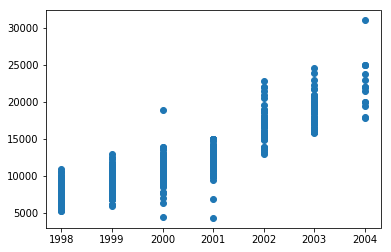

In [17]:
plt.scatter(post_data['Mfg_Year'], post_data['Price'])
plt.show()
 

In [18]:
post_data['After_2002'] = post_data.apply(lambda x: x['Mfg_Year'] < 2002, axis = 1)

In [19]:
dummy = pd.get_dummies(post_data['After_2002'], drop_first=True)
dummy.columns = ['After_2002']
post_data['After_2002'] = dummy['After_2002']
post_data['After_2002'].value_counts()

1    885
0    134
Name: After_2002, dtype: int64

### 모델을 살펴보니 VVT 라고 쓰여 있는 모델들이 평균 가격이 더 높다
### VVT인 모델과 아닌 모델로 구분해보자

In [20]:
#post_data.groupby('Model', as_index=True)['Price'].mean()

In [21]:
import re
pattern = re.compile(r'vvt', flags=re.IGNORECASE)
vvt= []
for i in post_data['Model']:
    result = pattern.search(i)
    if result:
        vvt.append(1)
    else:
        vvt.append(0)

post_data['vvt'] = pd.Series(vvt)

## R^2가 10% ~ 30%인 옵션들은 묶어서 연속형 변수로 만들어보자

In [22]:
post_data['Premium_option'] = post_data['CD_Player']+post_data['Airco']+post_data['Powered_Windows']+post_data['Central_Lock']+post_data['ABS']

### 변수들을 추가해 주었으니 Column에도 update 해주자

In [23]:
y_data = post_data['Price']
cols_nu = ['Age_08_04', 'Mfg_Year', 'KM', 'HP', 'CC', 'Quarterly_Tax', 'Weight','Guarantee_Period', 'Premium_option']
cols_cat = ['Model', 'Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Doors', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee',
            'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
            'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
            'Radio_cassette', 'Parking_Assistant', 'Tow_Bar','After_2002', 'vvt']

### 이제 단순 회귀분석을 다시 돌려보자

In [24]:
for i in cols_nu:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    nu_variable_stats.loc[i, 'R2'] = model.rsquared
    nu_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    nu_variable_stats.loc[i, 'Beta'] = model.params[1]
nu_variable_stats.sort_values('R2', ascending=False)

,R2,P-value,Beta
Mfg_Year,0.797988,0,2085.3
Age_08_04,0.781279,0,-171.649
KM,0.333567,1.03693e-91,-0.0551872
Premium_option,0.318851,7.06378e-87,1273.15
Weight,0.310266,4.1794e-84,39.2081
HP,0.0991609,6.8285e-25,76.8569
Quarterly_Tax,0.0319958,8.95663e-09,16.4635
Guarantee_Period,0.0276028,9.60109e-08,205.276
CC,0.0210399,3.33192e-06,2.83832


### 새로 추가된 Premium option 이라는 변수의 R^2가 나쁘지 않다

In [25]:
for i in cols_cat[1:]:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    cat_variable_stats.loc[i, 'R2'] = model.rsquared
    cat_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    cat_variable_stats.loc[i, 'Beta'] = model.params[1]

for i in cols_cat[1:]: 
    temp_dict = dict(post_data[i].value_counts())
    total = sum(temp_dict.values())
    for key in temp_dict.keys():
        cat_variable_stats.loc[i, key] = temp_dict[key] / float(total) * 100


cat_variable_stats.sort_values('R2', ascending=False)    



,R2,P-value,Beta,Petrol,CNG,Diesel,0,1,Blue,Grey,...,Violet,Green,White,Silver,Red,2,3,4,5,6
Model,0.916366,3.84556e-261,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
After_2002,0.664398,2.33686e-243,-8714.81,NaN,NaN,NaN,13.150147,86.849853,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boardcomputer,0.365576,1.3363e-102,4846.7,NaN,NaN,NaN,71.638862,28.361138,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Automatic_airco,0.354131,1.20611e-98,9063.62,NaN,NaN,NaN,94.013739,5.986261,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vvt,0.350618,1.91189e-97,4557.91,NaN,NaN,NaN,67.222767,32.777233,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD_Player,0.243082,1.58629e-63,4254.76,NaN,NaN,NaN,77.330716,22.669284,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Airco,0.197411,1.52604e-50,3210.9,NaN,NaN,NaN,49.558391,50.441609,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Powered_Windows,0.131775,4.26527e-33,2647.29,NaN,NaN,NaN,43.277723,56.722277,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Central_Lock,0.13047,9.19823e-33,2649.6,NaN,NaN,NaN,41.413150,58.586850,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABS,0.0926474,2.753e-23,2823.78,NaN,NaN,NaN,18.645731,81.354269,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Category 변수에서 새로 update한 'After 2002'와 'VVT'가 굉장히 높은 R^2값을 가지는 것을 볼 수 있다

# 자, 이제 다중회귀분석을 시작해보자

In [26]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [27]:
train_variable_1 = post_data[['Age_08_04', 'KM', 'Premium_option', 'Weight', 'After_2002','Boardcomputer','Automatic_airco', 'vvt'] ]

In [28]:
model = LinearRegression()
score = cross_val_score(model, train_variable_1, y_data, cv = KFold(n_splits=5, shuffle=True))
score

/Users/jangseunghyeon/.pyenv/versions/python2/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


array([ 0.85829981,  0.90461859,  0.89179278,  0.87988958,  0.90174865])

In [29]:
train_variable_1.tail() 

,Age_08_04,KM,Premium_option,Weight,After_2002,Boardcomputer,Automatic_airco,vvt
1014,71,29000,0,1045,1,0,0,0
1015,69,20544,4,1025,1,0,0,0
1016,71,17016,0,1015,1,0,0,0
1017,70,16916,0,1015,1,0,0,0
1018,76,82635,0,1114,1,0,0,0


In [30]:
dfy = data['Price']

In [33]:
train_variable_2 = pd.concat([dfy, train_variable_1], axis = 1)
train_variable_2.tail()

,Price,Age_08_04,KM,Premium_option,Weight,After_2002,Boardcomputer,Automatic_airco,vvt
1014,8950,71,29000,0,1045,1,0,0,0
1015,7500,69,20544,4,1025,1,0,0,0
1016,8500,71,17016,0,1015,1,0,0,0
1017,7250,70,16916,0,1015,1,0,0,0
1018,6950,76,82635,0,1114,1,0,0,0
